In [19]:
import os
import copy
import random
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

from service.data_setup import data_loader, data_preprocessing

In [21]:
def reset_seeds(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [4]:
df = data_loader(root = '.data', filename = 'WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
df = data_preprocessing(df)

c:\dev\github\SKN10-2nd-2Team\service\data_setup.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)
c:\dev\github\SKN10-2nd-2Team\service\data_setup.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   Partner                                7043 non-null   int64  
 2   Dependents                             7043 non-null   int64  
 3   tenure                                 7043 non-null   int64  
 4   PhoneService                           7043 non-null   int64  
 5   MultipleLines                          7043 non-null   float64
 6   OnlineSecurity                         7043 non-null   float64
 7   OnlineBackup                           7043 non-null   float64
 8   DeviceProtection                       7043 non-null   float64
 9   TechSupport                            7043 non-null   float64
 10  StreamingTV                            7043 non-null   float64
 11  Stre

In [7]:
X_df = df.drop("Churn", axis = 1)
y_df = df['Churn']

df.shape, X_df.shape, y_df.shape

((7043, 29), (7043, 28), (7043,))

In [8]:
reset_seeds()
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.3, stratify = df['Churn'], shuffle = True)

In [9]:
reset_seeds()
smote = SMOTE(sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train.shape, y_train.shape

((7244, 28), (7244,))

# Extra Trees

In [10]:
reset_seeds()
rf_hp = {
  "n_estimators" : [50, 100, 200, 400, 700, 1000, 1500],
  "max_features" : [None, "sqrt", "log2"],
  "max_depth" : np.arange(5, 15, 1),
  "min_samples_split" : [2, 3, 4]
}
rf = ExtraTreesClassifier()

rf_gs = GridSearchCV(rf, rf_hp, scoring = 'f1', n_jobs=-1, verbose=1).fit(X_train, y_train)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits


In [22]:
rf_gs.best_params_

{'max_depth': 14,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 200}

<Axes: >

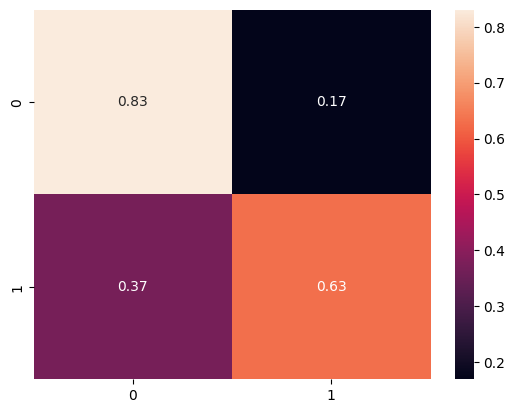

In [23]:
rf_gs_pred = rf_gs.predict(X_test)

sns.heatmap(confusion_matrix(y_test, rf_gs_pred, normalize="true"), annot = True)

In [24]:
rf_gs.score(X_test, y_test), f1_score(y_test, rf_gs_pred), roc_auc_score(y_test, rf_gs_pred)

(0.5998300764655905, 0.5998300764655905, 0.7298873743499275)

In [28]:
from service.models import ClassificationModels

rf_model = ClassificationModels('extratrees', rf_gs.best_params_)

rf_model.save_model()

TypeError: ClassificationModels.__init__() takes from 1 to 2 positional arguments but 3 were given